In [28]:
import numpy as np
import networkx as nx
from scipy.stats import norm
import matplotlib.pyplot as plt

# Define chaotic PRNG function
def chaotic_prng(r=3.9, x0=0.5, n=10):
    if not (0 < x0 < 1):
        raise ValueError("Initial value x0 must be between 0 and 1.")
    if not (0 < r <= 4):
        raise ValueError("Control parameter r must be between 0 and 4.")
    
    numbers = np.empty(n)
    x = x0
    for i in range(n):
        x = r * x * (1 - x)
        numbers[i] = x
    
    return numbers

# Define drift and diffusion functions
def mu(x):
    return -0.5 * x  # Example drift term (mean-reverting)

def sigma(x):
    return 0.1 * np.ones_like(x)  # Example diffusion term (constant volatility)

# Dynamic_Random_Graph class definition
class Dynamic_Random_Graph:
    def __init__(self, num_nodes, coupling_constants):
        self.graph = nx.Graph()
        self.num_nodes = num_nodes
        
        # Ensure coupling_constants is an array of length num_nodes
        if len(coupling_constants) != num_nodes:
            raise ValueError("Length of coupling_constants must match num_nodes.")
        
        self.coupling_constants = coupling_constants
        self.positions = np.random.rand(num_nodes)  # Initialize node positions
        self.create_graph()
        self.history_probabilities = []  # Store historical probabilities
        self.update_probabilities()

    def create_graph(self):
        for i in range(self.num_nodes):
            self.graph.add_node(i)
        
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                # Use a coupling constant from the array to determine edge probability
                coupling_constant_ij = (self.coupling_constants[i] + self.coupling_constants[j]) / 2
                if np.random.rand() < coupling_constant_ij:
                    self.graph.add_edge(i, j)

    def update_probabilities(self):
        degrees = np.array([self.graph.degree(n) for n in self.graph.nodes()])
        weighted_degrees = degrees ** self.coupling_constants
        total_weighted_degree = np.sum(weighted_degrees)
        self.probabilities = weighted_degrees / total_weighted_degree
        self.history_probabilities.append(self.probabilities.copy())  # Store current probabilities

    def simulate_sde(self, mu, sigma, dt, num_steps):
        for _ in range(num_steps):
            dW = np.random.normal(scale=np.sqrt(dt), size=self.num_nodes)
            self.positions += mu(self.positions) * dt + sigma(self.positions) * dW
            self.update_probabilities()

    def sample_distribution(self, num_samples):
        bins = np.arange(self.num_nodes)
        samples = np.random.choice(bins, size=num_samples, p=self.probabilities)
        return samples

    def sample_from_history(self, time_index, num_samples):
        if time_index < 0 or time_index >= len(self.history_probabilities):
            raise IndexError("Time index out of range.")
        
        bins = np.arange(self.num_nodes)
        samples = np.random.choice(bins, size=num_samples, p=self.history_probabilities[time_index])
        return samples

    def check_normalization(self):
        return np.isclose(np.sum(self.probabilities), 1.0)

In [29]:
# Define peptide vocabulary
vocabulary = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
              'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Function to generate peptide sequences
def sample_peptide_sequences(dynamic_graph, num_peptides, peptide_length):
    peptides = []
    for _ in range(num_peptides):
        sampled_nodes = dynamic_graph.sample_distribution(peptide_length)
        peptide = ''.join(vocabulary[node] for node in sampled_nodes)
        peptides.append(peptide)
    return peptides

# Parameters
num_nodes = len(vocabulary)  # Set number of nodes equal to the size of the vocabulary
r = 1.5
x0 = 0.5
coupling_constants = chaotic_prng(r, x0, num_nodes)  # Generate chaotic coupling constants
dt = 0.01
num_steps = 10000

# Create dynamic random graph and simulate SDE dynamics
dynamic_graph = Dynamic_Random_Graph(num_nodes=num_nodes, coupling_constants=coupling_constants)
dynamic_graph.simulate_sde(mu, sigma, dt, num_steps)

Sampled Peptide Sequences:
1: TDRATVIWFMFQGHAKIMNQDEFRKCMKKREFLGMGVKHKKPNQLIMCEQEHTVDDLMGIQCVNHWVWCKAWFKSYTYWPQIKDGLSNFMWQHGVYKMLL
2: DWLMTWRICGSSLDWPVKRGELPFHLDLTAEKRLAMWVMCAKEADISWSLLQPEPEMNNRGWDQIGYCLNNDVTYQSGYESMGDWNNELLKHAHPHLVEM
3: NWRSALHTMTERKQRTRNFLKCFAMSLRKQFCYDVGLVHWVDAVDMDKQHWFKPGVLMARNLSILWKSMKPEIAYHLDHWGWYMEQMIGGEISGMDYNVL
4: ATWHRGHMNLNNGLFNHCHSARPIQVINARCLRWTIKLYMKLWVKCKATERMANKLGTDAADSLWHGMNKAQASSDNVSLQLWMYTWRRACLLSRTCWMY
5: TADLRIAHKCERSIEQNLPSMSNWSHPCSGCSKQSQKPWEPGLYRQPIQMALEKKRPSETAGLRTHQARMGTNNDIMSTKCLRIFTGCLDLSPFVHHKVM
6: MTHSDQRDSLKAVLMNRSQQGRNMYLIKRWDYYNYCKCFEVFKSSLYGCHIWFMNTFFFKMHTSCPIDLELTVANWNGRAFRRNYAMTDPFIRCRRFWAM
7: RLLIFSHCVLRHGCPDLDSHPFHRGQYPYTMFICRGTDLIHEQQQCNQRNHTAWHMNHNFWSNMDSPMNYRHQWSDPTAQMCGFIIDFQTMQDERCLWQF
8: QVMHRNHSHAMLCDTDICWRCDNARHMGQASQFDYQYTTFQFMIGVKPFLFCDHGSWECHRHDTRICWDDNKLMWLLQGGAQYIGDSSNTNFKAHDIKTD
9: RLKWGFLKCAGEPLMPDHGSPEQDHTDDWDIGLMTPTPVDRDPWCPFGFRGRYIPQPIVIWVPFGPQARIGIMRKPIRYSVDAFSQFCPQYHSEDMVAQN
10: IKHLTCWSGIYHIIMFMVRAQSPIDHDMEQELK

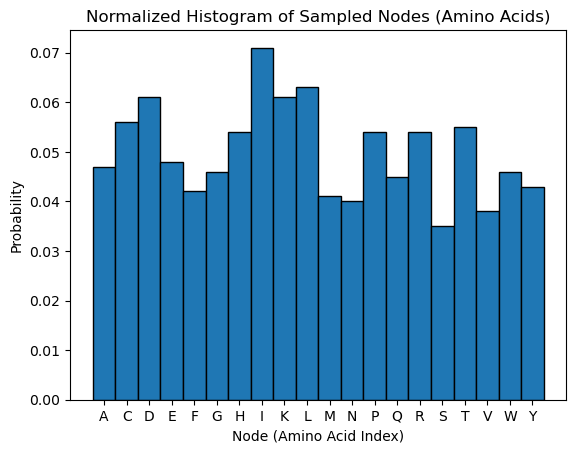

In [30]:
# Peptide sampling parameters
peptide_length = 100  # Length of each peptide
num_peptides = 10   # Number of peptides to sample

# Sample peptides from the probability distribution
sampled_peptides = sample_peptide_sequences(dynamic_graph, num_peptides, peptide_length)

# Print the sampled peptide sequences
print("Sampled Peptide Sequences:")
for i, peptide in enumerate(sampled_peptides, 1):
    print(f"{i}: {peptide}")

# Example usage: plot the distribution of sampled nodes (for visualization purposes)
samples = dynamic_graph.sample_distribution(num_samples=1000)
plt.hist(samples, bins=np.arange(dynamic_graph.num_nodes + 1) - 0.5, density=True, edgecolor='black')
plt.xlabel('Node (Amino Acid Index)')
plt.ylabel('Probability')
plt.title('Normalized Histogram of Sampled Nodes (Amino Acids)')
plt.xticks(np.arange(dynamic_graph.num_nodes), vocabulary)
plt.show()